In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Gestión de los datos del DataSet

In [2]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_data_path = "/kaggle/input/bird-species-classification-220-categories/Train"
test_data_path = "/kaggle/input/bird-species-classification-220-categories/Test"

In [3]:
train_data_gen = train_gen.flow_from_directory(
    train_data_path,
    target_size=(150,150),
    batch_size=128,
    class_mode="categorical",
    color_mode="rgb",
    subset="training")

validation_data_gen = test_gen.flow_from_directory(
    test_data_path,
    target_size=(150,150),
    batch_size=128,
    class_mode="categorical",
    color_mode="rgb",
    subset="validation")

test_data_gen = test_gen.flow_from_directory(
    test_data_path,
    target_size=(150,150),
    batch_size=128,
    class_mode="categorical",
    color_mode="rgb")

Found 9414 images belonging to 200 classes.
Found 397 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [4]:
def plotImages(images_array):
  fig,axes = plt.subplots(1,5,figsize = (10,10))
  axes = axes.flatten()
  for img, ax in zip(images_array,axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

In [5]:
def visualization_result(history):
  epochs = [i for i in range(20)]
  fig,ax= plt.subplots(1,2)
  train_accuracy = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16,9)

  ax[0].plot(epochs,train_accuracy,"go-",label="Accuracy Training")
  ax[0].plot(epochs,val_acc,"ro-",label="Accuracy Validation Training")
  ax[0].set_title("Accuracy Validation & Training")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")


  ax[1].plot(epochs,train_loss,"go-",label="Loss Training")
  ax[1].plot(epochs,val_loss,"ro-",label="loss Validation Training")
  ax[1].set_title("Loss Validation & Training")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Accuracy")

  plt.show()

In [6]:
classes = list(train_data_gen.class_indices.keys())

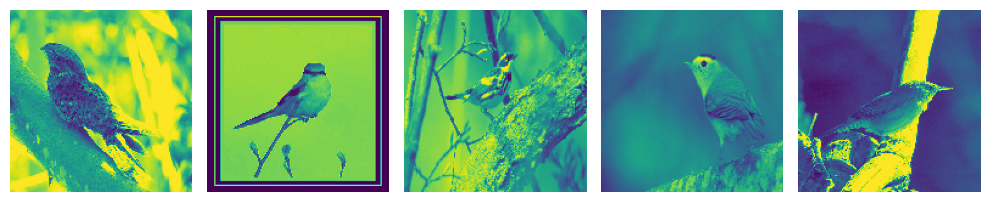

In [7]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Modelo red Neuronal

In [8]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3),
                padding="same",kernel_regularizer=regularizers.l2(1e-4)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),activation="relu",padding="same",
                 kernel_regularizer=regularizers.l2(1e-4)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu",padding="same",
                 kernel_regularizer=regularizers.l2(1e-4)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation="relu",padding="same",
                 kernel_regularizer=regularizers.l2(1e-4)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(len(classes),activation="softmax"))


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 75, 75, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                        

In [9]:
model.compile(optimizer=optimizers.Adam(),loss="categorical_crossentropy",
             metrics=['accuracy'])

In [10]:
callback_best_model = ModelCheckpoint(
    'my_best_model.hdf5',
    verbose=1,
    save_best_only=True,
    frecuency="epochs",
    save_weights_only=False,
    monitor="val_accuracy")

In [11]:
callback_earlystopping = EarlyStopping(monitor="loss",patience=15,mode="auto")

In [12]:
history_model = model.fit(
    train_data_gen,
    epochs=100,
    callbacks=[callback_best_model,callback_earlystopping],
    validation_data=validation_data_gen
)

Epoch 1/100


2023-12-19 16:49:39.789630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 [==============================] - ETA: 0s - loss: 6.5636 - accuracy: 0.0305
Epoch 1: val_accuracy improved from -inf to 0.00756, saving model to my_best_model.hdf5
74/74 [==============================] - 118s 1s/step - loss: 6.5636 - accuracy: 0.0305 - val_loss: 6.0917 - val_accuracy: 0.0076
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - ETA: 0s - loss: 4.6765 - accuracy: 0.1495
Epoch 2: val_accuracy improved from 0.00756 to 0.01511, saving model to my_best_model.hdf5
74/74 [==============================] - 42s 563ms/step - loss: 4.6765 - accuracy: 0.1495 - val_loss: 6.8630 - val_accuracy: 0.0151
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 3.2039 - accuracy: 0.3150
Epoch 3: val_accuracy did not improve from 0.01511
74/74 [==============================] - 41s 548ms/step - loss: 3.2039 - accuracy: 0.3150 - val_loss: 6.8221 - val_accuracy: 0.0050
Epoch 4/100
74/74 [==============================] - ETA: 0s - loss: 2.0015 - accuracy: 0.5082
Epoch 4: val_accuracy did not improve from 0.01511
74/74 [==============================] - 41s 553ms/step - loss: 2.0015 - accuracy: 0.5082 - val_loss: 6.8154 - val_accuracy: 0.0101
Epoch 5/100
74/74 [==============================] - ETA: 0s - loss: 1.2233 - accuracy: 0.6880
Epoch 5: val_accuracy improved from 0.01511

In [13]:
result_model = model.evaluate(test_data_gen)

19/19 [==============================] - 26s 1s/step - loss: 9.9693 - accuracy: 0.1352


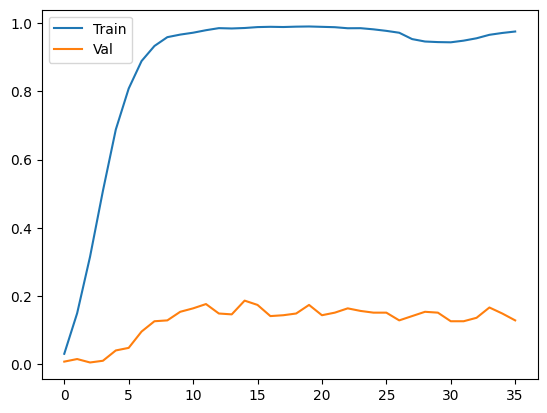

In [14]:
plt.plot(history_model.history['accuracy'],label="Train")
plt.plot(history_model.history['val_accuracy'],label="Val")
plt.legend()
plt.show()

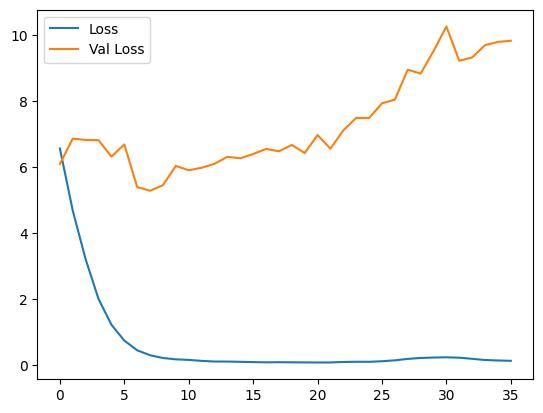

In [15]:
plt.plot(history_model.history['loss'],label="Loss")
plt.plot(history_model.history['val_loss'],label="Val Loss")
plt.legend()
plt.show()